## 1. Import Libraries

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, Model

## 2. Explore the Dataset

In [2]:
# Load training CSV
train_df = pd.read_csv('training_set_pixel_size_and_HC.csv')
test_df = pd.read_csv('test_set_pixel_size.csv')

print("Training Data:")
print(train_df.head())
print(f"\nShape: {train_df.shape}")

Training Data:
     filename  pixel size(mm)  head circumference (mm)
0  000_HC.png        0.069136                    44.30
1  001_HC.png        0.089659                    56.81
2  002_HC.png        0.062033                    68.75
3  003_HC.png        0.091291                    69.00
4  004_HC.png        0.061240                    59.81

Shape: (999, 3)


In [3]:
# Statistics of Head Circumference
print("Head Circumference Statistics:")
print(train_df['head circumference (mm)'].describe())

Head Circumference Statistics:
count    999.000000
mean     174.383093
std       65.282061
min       44.300000
25%      153.600000
50%      174.060000
75%      189.825000
max      346.400000
Name: head circumference (mm), dtype: float64


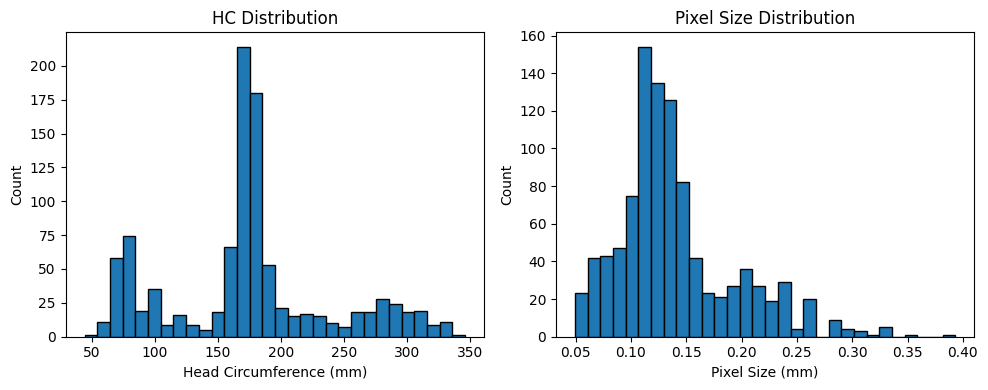

In [20]:
# Plot HC distribution
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(train_df['head circumference (mm)'], bins=30, edgecolor='black')
plt.xlabel('Head Circumference (mm)')
plt.ylabel('Count')
plt.title('HC Distribution')

plt.subplot(1, 2, 2)
plt.hist(train_df['pixel size(mm)'], bins=30, edgecolor='black')
plt.xlabel('Pixel Size (mm)')
plt.ylabel('Count')
plt.title('Pixel Size Distribution')
plt.tight_layout()
plt.show()

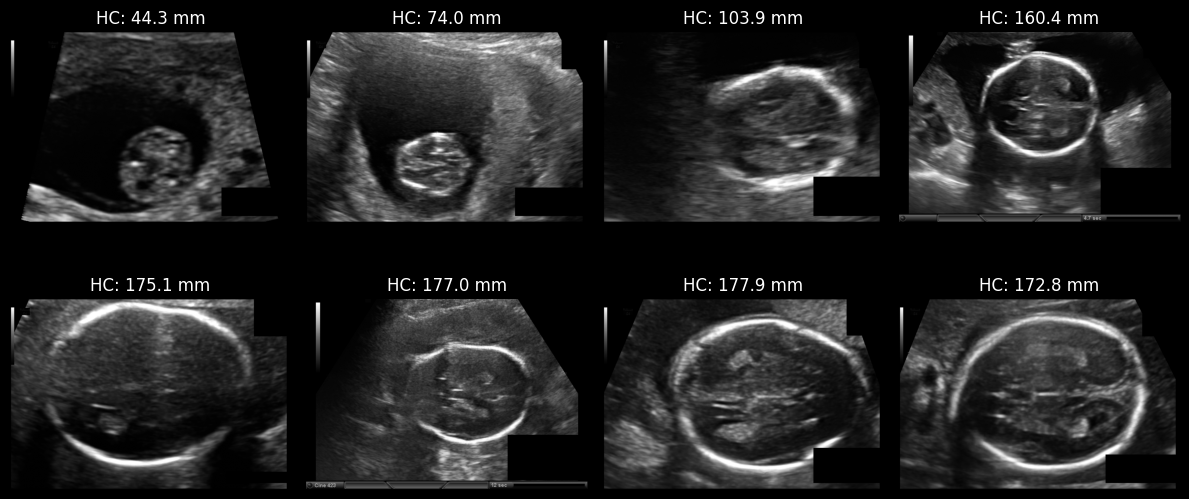

In [5]:
# Display sample images
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    filename = train_df.iloc[i*100]['filename']
    hc = train_df.iloc[i*100]['head circumference (mm)']
    img = Image.open(f'training_set/{filename}')
    ax.imshow(img, cmap='gray')
    ax.set_title(f'HC: {hc:.1f} mm')
    ax.axis('off')
plt.tight_layout()
plt.show()

## 3. Data Preprocessing

In [6]:
IMG_SIZE = 128

def load_images(df, folder, has_hc=True):
    images = []
    pixel_sizes = []
    hc_values = [] if has_hc else None
    
    for idx, row in df.iterrows():
        img_path = os.path.join(folder, row['filename'])
        if os.path.exists(img_path):
            # Load and preprocess image
            img = Image.open(img_path).convert('L')
            img = img.resize((IMG_SIZE, IMG_SIZE))
            img_array = np.array(img) / 255.0
            
            images.append(img_array)
            pixel_sizes.append(row['pixel size(mm)'])
            if has_hc:
                hc_values.append(row['head circumference (mm)'])
    
    images = np.array(images)[..., np.newaxis]  # Add channel dimension
    pixel_sizes = np.array(pixel_sizes, dtype=np.float32)
    
    if has_hc:
        return images, pixel_sizes, np.array(hc_values, dtype=np.float32)
    return images, pixel_sizes

In [7]:
# Load training data
print("Loading training images...")
X, pixel_sizes, y = load_images(train_df, 'training_set', has_hc=True)
print(f"Loaded {len(X)} images")
print(f"Image shape: {X.shape}")
print(f"HC range: {y.min():.1f} - {y.max():.1f} mm")

Loading training images...
Loaded 999 images
Image shape: (999, 128, 128, 1)
HC range: 44.3 - 346.4 mm


In [8]:
ps_mean, ps_std = pixel_sizes.mean(), pixel_sizes.std()
pixel_sizes_norm = (pixel_sizes - ps_mean) / ps_std

# Split train/validation
X_train, X_val, ps_train, ps_val, y_train, y_val = train_test_split(
    X, pixel_sizes_norm, y, test_size=0.2, random_state=42
)

print(f"Training: {len(X_train)} samples")
print(f"Validation: {len(X_val)} samples")

Training: 799 samples
Validation: 200 samples


## 4. Build CNN Model

In [9]:
def build_cnn_model():
    img_input = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1), name='image')
    
    # CNN backbone
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(img_input)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    
    # Pixel size input
    ps_input = layers.Input(shape=(1,), name='pixel_size')

    # Combine features
    combined = layers.Concatenate()([x, ps_input])
    combined = layers.Dense(32, activation='relu')(combined)

    output = layers.Dense(1, name='hc_output')(combined)
    
    model = Model(inputs=[img_input, ps_input], outputs=output)
    return model

model = build_cnn_model()
model.summary()

2026-01-23 23:08:46.515251: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 128, 128,  │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        320 │ image[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ max_pooling2d_2[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      8,256 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pixel_size          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 65)        │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ pixel_size[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,112 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hc_output (Dense)   │ (None, 1)         │         33 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 103,073 (402.63 KB)

 Trainable params: 103,073 (402.63 KB)

 Non-trainable params: 0 (0.00 B)

## 5. Train Model with MAE

In [10]:
# Compile with MAE loss
model.compile(
    optimizer='adam',
    loss='mae',
    metrics=['mae']
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_mae', patience=10, restore_best_weights=True
)

In [11]:
# Train the model
history = model.fit(
    {'image': X_train, 'pixel_size': ps_train},
    y_train,
    validation_data=({'image': X_val, 'pixel_size': ps_val}, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 283ms/step - loss: 165.2479 - mae: 165.2479 - val_loss: 129.1216 - val_mae: 129.1216
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 250ms/step - loss: 79.1589 - mae: 79.1589 - val_loss: 64.8841 - val_mae: 64.8841
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 248ms/step - loss: 65.0175 - mae: 65.0175 - val_loss: 55.9823 - val_mae: 55.9823
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 295ms/step - loss: 61.1571 - mae: 61.1571 - val_loss: 51.3725 - val_mae: 51.3725
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 248ms/step - loss: 59.1661 - mae: 59.1661 - val_loss: 48.0060 - val_mae: 48.0060
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 250ms/step - loss: 55.7916 - mae: 55.7916 - val_loss: 48.2335 - val_mae: 48.2335
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 258ms/step - loss: 52.2697 - mae: 52.2697 - val_loss: 52.2461 - val_mae: 52.2461
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 257ms/step - loss: 52.4547 - mae: 52.4547 - val_loss: 43.1919 - val_mae: 43.1919
Epoch 9/50
25/25 ━━━

## 6. Evaluate Model

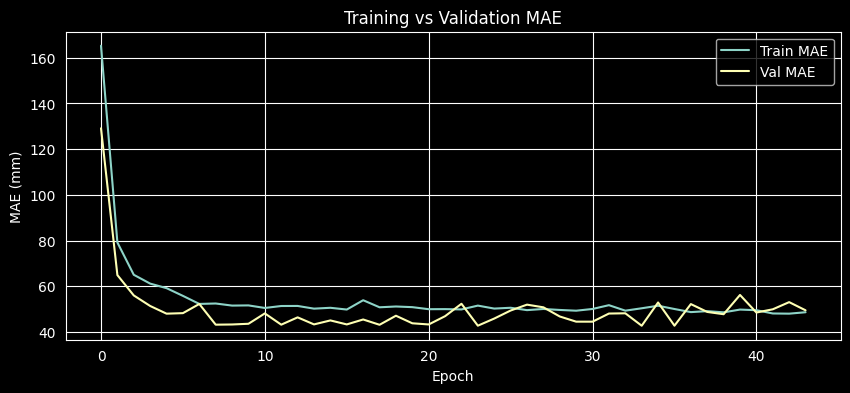

In [12]:
# Plot training history
plt.figure(figsize=(10, 4))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE (mm)')
plt.title('Training vs Validation MAE')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
val_pred = model.predict({'image': X_val, 'pixel_size': ps_val})
val_mae = np.mean(np.abs(y_val - val_pred.flatten()))
print(f"\n Final validation MAE: {val_mae:.2f} mm ")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step

 Final validation MAE: 42.73 mm 


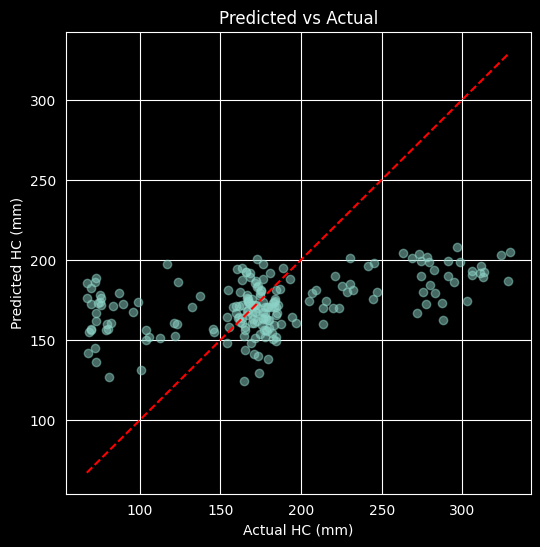

In [14]:
# Scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(y_val, val_pred.flatten(), alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel('Actual HC (mm)')
plt.ylabel('Predicted HC (mm)')
plt.title('Predicted vs Actual')
plt.grid(True)
plt.show()

## 7. Predict on Test Set

In [15]:
# Load test data
print("Loading test images...")
X_test, ps_test = load_images(test_df, 'test_set', has_hc=False)
ps_test_norm = (ps_test - ps_mean) / ps_std
print(f"Loaded {len(X_test)} test images")

Loading test images...
Loaded 335 test images


In [16]:
# Predict
test_pred = model.predict({'image': X_test, 'pixel_size': ps_test_norm})

# Save predictions
results = pd.DataFrame({
    'filename': test_df['filename'].values[:len(test_pred)],
    'predicted_hc_mm': test_pred.flatten()
})
results.to_csv('test_predictions_notebook.csv', index=False)
print("Predictions saved to test_predictions_notebook.csv")
print(results.head(10))

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
Predictions saved to test_predictions_notebook.csv
     filename  predicted_hc_mm
0  000_HC.png       209.892929
1  001_HC.png       181.051956
2  002_HC.png       170.506485
3  003_HC.png       169.619553
4  004_HC.png       179.618286
5  005_HC.png       149.266678
6  006_HC.png       157.610611
7  007_HC.png       159.615326
8  008_HC.png       189.484344
9  009_HC.png       202.897232


## 8. Save Model

In [17]:
model.save('hc_model_notebook.keras')
print("Model saved!")

Model saved!
